In [1]:
# Проведем A/B–тестирование
# В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
# Проанализируем итоги эксперимента и сделаем вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [10]:
# Прочитаем имеющиеся файлы и проверим их содержимое, предвариетльно установив необходимые библиотеки


In [61]:
%pip install seaborn
import pandas as pd
from urllib.parse import urlencode
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

Defaulting to user installation because normal site-packages is not writeable
,Requirement already satisfied: seaborn in /opt/tljh/user/lib/python3.7/site-packages (0.11.1)
,Requirement already satisfied: matplotlib>=2.2 in /opt/tljh/user/lib/python3.7/site-packages (from seaborn) (3.2.1)
,Requirement already satisfied: pandas>=0.23 in /opt/tljh/user/lib/python3.7/site-packages (from seaborn) (1.1.2)
,Requirement already satisfied: numpy>=1.15 in /opt/tljh/user/lib/python3.7/site-packages (from seaborn) (1.21.2)
,Requirement already satisfied: scipy>=1.0 in /opt/tljh/user/lib/python3.7/site-packages (from seaborn) (1.7.1)
,Requirement already satisfied: cycler>=0.10 in /opt/tljh/user/lib/python3.7/site-packages (from matplotlib>=2.2->seaborn) (0.10.0)
,Requirement already satisfied: kiwisolver>=1.0.1 in /opt/tljh/user/lib/python3.7/site-packages (from matplotlib>=2.2->seaborn) (1.2.0)
,Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /opt/tljh/user/lib/python3

In [62]:
# Базовый URL API Яндекс.Диска
disk_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"

# Ссылка на папку
public_key = "https://disk.yandex.ru/d/XNdgle4oWXrLCA"

# Файлы и их пути
file_paths = {
    "groups.csv": "/groups.csv",
    "group_add.csv": "/group_add.csv",
    "active_studs.csv": "/active_studs.csv",
    "checks.csv": "/checks.csv"
}

# Функция для получения прямой ссылки
def get_download_link(public_key, file_path):
    response = requests.get(disk_url, params={"public_key": public_key, "path": file_path})
    if response.status_code == 200:
        return response.json()["href"]
    else:
        print(f"Ошибка при получении ссылки для {file_path}: {response.status_code}")
        return None

# Функция для скачивания файлов
def download_file(file_name, download_url):
    response = requests.get(download_url, allow_redirects=True)
    if response.status_code == 200:
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"Файл {file_name} скачан!")
    else:
        print(f"Ошибка при скачивании {file_name}: {response.status_code}")

# Скачивание файлов
for file_name, file_path in file_paths.items():
    download_link = get_download_link(public_key, file_path)
    if download_link:
        download_file(file_name, download_link)

# Читаем CSV-файлы в DataFrame
groups = pd.read_csv("groups.csv", sep=";")
group_add = pd.read_csv("group_add.csv", sep=",")  
active_studs = pd.read_csv("active_studs.csv", sep=",")
checks = pd.read_csv("checks.csv", sep=";")

# Проверка данных
print(groups.head())
print(group_add.head())
print(active_studs.head())
print(checks.head())

Файл groups.csv скачан!
,Файл group_add.csv скачан!
,Файл active_studs.csv скачан!
,Файл checks.csv скачан!
,     id grp
,0  1489   B
,1  1627   A
,2  1768   B
,3  1783   B
,4  1794   A
,        id grp
,0  5694584   B
,1  5694830   B
,2  5695057   B
,3  5698872   B
,4  5699067   B
,   student_id
,0      581585
,1     5723133
,2     3276743
,3     4238589
,4     4475369
,   student_id    rev
,0        1627  990.0
,1        3185  690.0
,2       25973  690.0
,3       26280  690.0
,4      100300  990.0


In [63]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [64]:
# проверим есть ли в таблице пропущенные значения
missing_count = groups.isnull().sum()
print(missing_count)

id     0
,grp    0
,dtype: int64


In [65]:
# проверим наличие дубликатов
groups.duplicated().sum()

0

In [66]:
# найдем количество уникальных id
groups.id.nunique()

74484

In [67]:
# тоже самое продетаем с остальными датасетами
# рассматриваем дополнительный файл с пользователями, который нам прислали спустя 2 дня после передачи данных
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [68]:
group_add.duplicated().sum()

0

In [69]:
# рассматриваем файл с информацией об оплатах пользователей в дни проведения эксперимента 
checks.student_id.nunique()


541

In [70]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [71]:
checks.duplicated().sum()

0

In [72]:
# рассматриваем файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs.isna().sum()

student_id    0
dtype: int64

In [73]:
# как мы видим, пропусков и дублей нет. следующий шаг - объединение таблиц
all_users = groups.merge(group_add, how='outer', on=['id', 'grp'])
all_users.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [74]:
# в соединенном датасете проверим количество пропусков и дубликатов
all_users.isna().sum()

id     0
grp    0
dtype: int64

In [75]:
all_users.duplicated().sum()

0

In [76]:
# для удобства соединения таблиц перименуем столбцы в табоице active_studs
# также для удобства фильтрования добавим в датасет active_studs дополнительную калонку "be_on_platform" со значением 1, 
# в дальнейшем это поможет нам отобрать только тех пользователей которые были активны в период теста
active_studs = active_studs.rename(columns={'student_id': 'id'})
active_studs.insert(loc=1, column='be_on_platform', value=1)
active_studs.head()

,id,be_on_platform
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [77]:
# также переименуем столбцы в таблице checks
checks = checks.rename(columns={'student_id': 'id'})
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [78]:
# соединим таблицы со всеми пользователями и теми ко зашел в дни теста
all_users_in_test_days = all_users.merge(active_studs, how='outer', on='id')
all_users_in_test_days.head()

,id,grp,be_on_platform
0,1489,B,NaN
1,1627,A,1.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


In [79]:
# мы видим, что в ячейках пользователй, которые отсутствовали в дни теста пропуски. заполним их 0
all_users_in_test_days['be_on_platform'] = all_users_in_test_days['be_on_platform'].fillna(0) 
all_users_in_test_days.head()

,id,grp,be_on_platform
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


In [80]:
# далее мы присоединим датасет с оплатами. пропущенные ячейки заполним 0
all_users_in_test_days = all_users_in_test_days.merge(checks, how='outer', on='id')
all_users_in_test_days.rev = all_users_in_test_days.rev.fillna(0)
all_users_in_test_days.head()

,id,grp,be_on_platform,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [81]:
#  проверим на сколько успешно прошло соединение таблиц
all_users_in_test_days.isna().sum()

id                0
grp               0
be_on_platform    0
rev               0
dtype: int64

In [82]:
all_users_in_test_days.duplicated().sum()

0

In [83]:
# проверим, есть ли пользователи, которые не заходили на платформу во время теста, но совершили платеж
all_users_in_test_days.query('be_on_platform == 0 and rev!= 0').shape[0] 

149

In [84]:
# мы видим, что такие пользователи есть, возможно, это ошибка в данных. 
# однако, мы должны взять это во внимание и отфильтровать при дальнейше работе 

In [85]:
# определим количество пользователей, которые были на платформе во время теста
active_users = all_users_in_test_days.query('be_on_platform == 1')
unique_active_users_ids = active_users['id'].nunique()
print(f"Число уникальных id: {unique_active_users_ids}")

Число уникальных id: 8341


In [86]:
active_users.head()

,id,grp,be_on_platform,rev
1,1627,A,1.0,990.0
10,2085,B,1.0,0.0
12,2215,B,1.0,0.0
43,3391,A,1.0,0.0
45,3401,B,1.0,0.0


In [87]:
# Подсчет количества студентов в группе A
group_A_count = active_users.query("grp == 'A'").shape[0]

# Подсчет количества студентов в группе B
group_B_count = active_users.query("grp == 'B'").shape[0]

print(f"Количество пользователей в группе A: {group_A_count}")
print(f"Количество пользователей в группе B: {group_B_count}")

Количество пользователей в группе A: 1538
,Количество пользователей в группе B: 6803


In [88]:
# мы видим, что в группе B пользователей в несколько раз больше

In [89]:
# рассчитаем статистические величины 
stat_describe_active_users = active_users.groupby('grp').rev.describe().reset_index()
stat_describe_active_users


,grp,count,mean,std,min,25%,50%,75%,max
0,A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
1,B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


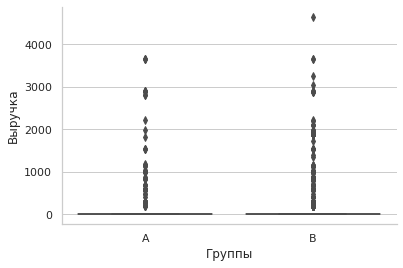

In [90]:
# построим график покупок из обоих групп. по графику мы видим, что большинство пользователей из обеих групп не совершили покупку
ax = sns.boxplot(x='grp', y='rev', data=active_users)
ax.set(xlabel='Группы', ylabel='Выручка')
sns.despine()

In [91]:
# далее рассмотрим только тех пользователей, которые совершили оплату
paying_users = active_users.query('rev != 0')
paying_users

,id,grp,be_on_platform,rev
1,1627,A,1.0,990.0000
220,100300,B,1.0,990.0000
320,108270,B,1.0,290.0000
3779,264473,B,1.0,1900.0001
4187,274352,B,1.0,690.0000
...,...,...,...,...
74365,5645737,B,1.0,1900.0000
74381,5651566,B,1.0,1900.0000
74402,5662322,B,1.0,1900.0000
74452,5681918,B,1.0,1900.0000


In [92]:
stat_describe_paying_users = paying_users.groupby('grp').rev.describe().reset_index()
stat_describe_paying_users

,grp,count,mean,std,min,25%,50%,75%,max
0,A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
1,B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


In [93]:
# подсчитаем кол-во пользователей в группах по платящим
group_A_paying = paying_users.query("grp == 'A'").shape[0]
group_B_paying = paying_users.query("grp == 'B'").shape[0]

print(f"Количество платящих пользователей в группе A: {group_A_paying}")
print(f"Количество платящих пользователей в группе B: {group_B_paying}")

Количество платящих пользователей в группе A: 78
,Количество платящих пользователей в группе B: 314


In [94]:
# Подсчитаем конверсию в платящего
conversion_rate_A = (group_A_paying/group_A_count)*100
conversion_rate_B = (group_B_paying/group_B_count)*100
print(f"Конверсия в платящего в группе A: {conversion_rate_A:.2f}%")
print(f"Конверсия в платящего в группе B: {conversion_rate_B:.2f}%")

Конверсия в платящего в группе A: 5.07%
,Конверсия в платящего в группе B: 4.62%


In [95]:
# выделяем контрольную группу
control_group_A = paying_users.query('grp == "A"')
# отобразим сводную статистику по контрольной группе группе
control_group_A.describe()


,id,be_on_platform,rev
count,7.800000e+01,78.0,78.000000
mean,2.924680e+06,1.0,933.589744
std,1.657487e+06,0.0,919.932711
min,1.627000e+03,1.0,199.000000
25%,1.403057e+06,1.0,290.000000
50%,3.176553e+06,1.0,585.000000
75%,4.345213e+06,1.0,1114.750000
max,5.577840e+06,1.0,3660.000000


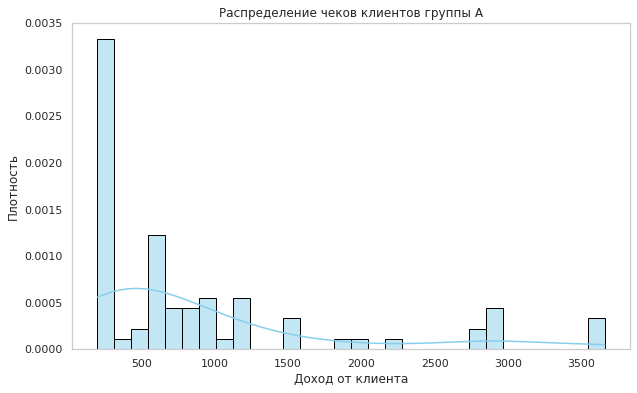

In [96]:
# проверим нормальность распределения группы А
sns.set(style="whitegrid")

# Построение гистограммы с кривой плотности
plt.figure(figsize=(10, 6))
sns.histplot(control_group_A['rev'], bins=30, kde=True, stat="density", color='skyblue', edgecolor='black')
plt.title('Распределение чеков клиентов группы А')
plt.xlabel('Доход от клиента')
plt.ylabel('Плотность')
plt.grid()
plt.show()

In [97]:
# выделяем тестовую группу группу
test_group_B = paying_users.query('grp == "B"')
# отобразим сводную статистику по тестовой группе
test_group_B.describe()


,id,be_on_platform,rev
count,3.140000e+02,314.0,314.000000
mean,2.829809e+06,1.0,1257.878992
std,1.610683e+06,0.0,790.864254
min,1.003000e+05,1.0,199.000000
25%,1.290454e+06,1.0,511.750000
50%,3.092955e+06,1.0,1140.000000
75%,4.192409e+06,1.0,1900.000000
max,5.740903e+06,1.0,4650.000000


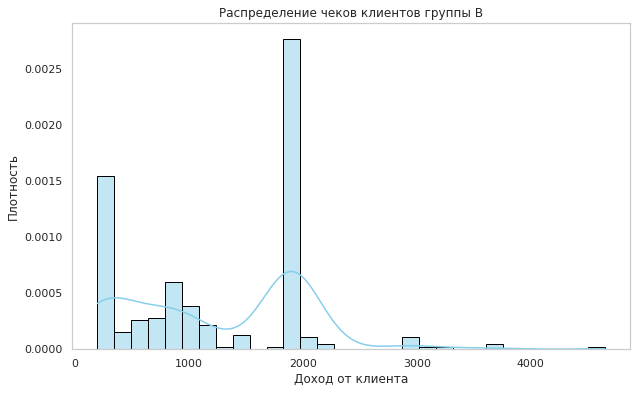

In [98]:
# проверим нормальность распределения группы В
sns.set(style="whitegrid")

# Построение гистограммы с кривой плотности
plt.figure(figsize=(10, 6))
sns.histplot(test_group_B['rev'], bins=30, kde=True, stat="density", color='skyblue', edgecolor='black')
plt.title('Распределение чеков клиентов группы В')
plt.xlabel('Доход от клиента')
plt.ylabel('Плотность')
plt.grid()
plt.show()

In [99]:
# рассчитаем, какой доход мы получилии от каждой группы. мы видим, что группа В принесла больший доход. Это объясняется тем, что кол-во наблюдаемых в этой группе в несколько раз больше. 
# Поэтому в анлизе будем принимать во внимание другие показатели
revenue_A = control_group_A.rev.sum()
revenue_B = test_group_B.rev.sum()
print(f"Общий доход от группы A: {revenue_A}")
print(f"Общий доход от группы B: {revenue_B}")

Общий доход от группы A: 72820.0
,Общий доход от группы B: 394974.0035


In [100]:
# рассчитаем ARPU
arpu_a = (control_group_A.rev.sum() / control_group_A.id.nunique()).round(2)
arpu_b = (test_group_B.rev.sum() / test_group_B.id.nunique()).round(2)
print(f"ARPU группы A: {arpu_a}")
print(f"ARPU группы B: {arpu_b}")

ARPU группы A: 933.59
,ARPU группы B: 1257.88


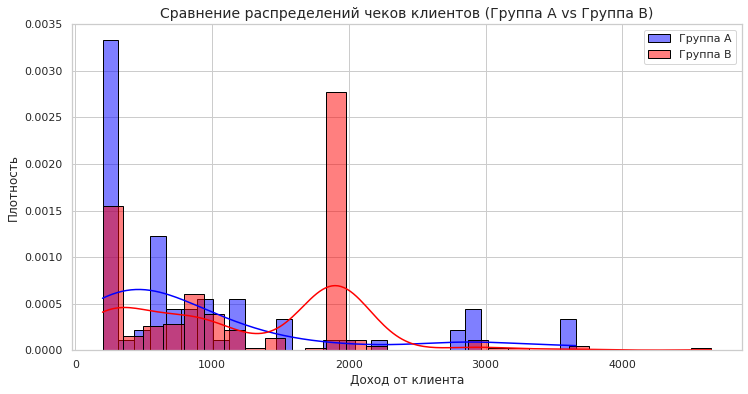

In [101]:
# отобразим графики вместе для визуального удобства
# Настройка стиля
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))

# Гистограммы с KDE для обеих групп
sns.histplot(control_group_A['rev'], bins=30, kde=True, stat="density", color='blue', edgecolor='black', label='Группа A', alpha=0.5)
sns.histplot(test_group_B['rev'], bins=30, kde=True, stat="density", color='red', edgecolor='black', label='Группа B', alpha=0.5)

# Добавление подписей
plt.title('Сравнение распределений чеков клиентов (Группа A vs Группа B)', fontsize=14)
plt.xlabel('Доход от клиента', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend()  # Легенда для различения групп
plt.grid(True)

# Показ графика
plt.show()

In [102]:
# визуально мы склоняемся к тому, что данные распределены не нормально. проверим эту гипотезу при помощи теста Шапиро-Уилка

shapiro_test_A = stats.shapiro(control_group_A['rev'])
print('Статистика теста группы А:', shapiro_test_A.statistic)
print('p-значение:', shapiro_test_A.pvalue)

# Интерпретация результата
alpha = 0.05
if shapiro_test_A.pvalue > alpha:
    print("Не отклоняем нулевую гипотезу: данные в группе А нормально распределены")
else:
    print("Отклоняем нулевую гипотезу: данные в группе А не нормально распределены")


shapiro_test_B = stats.shapiro(test_group_B['rev'])
print('Статистика теста группы А:', shapiro_test_B.statistic)
print('p-значение:', shapiro_test_B.pvalue)

# Интерпретация результата
alpha = 0.05
if shapiro_test_B.pvalue > alpha:
    print("Не отклоняем нулевую гипотезу: данные в группе B нормально распределены")
else:
    print("Отклоняем нулевую гипотезу: данные в группе B не нормально распределены")


Статистика теста группы А: 0.7353236079216003
,p-значение: 1.4986822893803264e-10
,Отклоняем нулевую гипотезу: данные в группе А не нормально распределены
,Статистика теста группы А: 0.8547235727310181
,p-значение: 1.5437024585965894e-16
,Отклоняем нулевую гипотезу: данные в группе B не нормально распределены


In [103]:
# мы подтвердили ненормальность распределения 

In [104]:
# сравним медианы групп
median_A = control_group_A['rev'].median()
median_B = test_group_B['rev'].median()

print(f"Медиана группы A: {median_A}")
print(f"Медиана группы B: {median_B}")

if median_A > median_B:
 print("Группа A имеет более высокую медиану.")
else:
 print("Группа B имеет более высокую медиану.")

Медиана группы A: 585.0
,Медиана группы B: 1140.0
,Группа B имеет более высокую медиану.


In [105]:
# Подсчет количества студентов в группе A
group_A_active_users = active_users.query("grp == 'A'")
group_B_active_users = active_users.query("grp == 'B'")

control_group_A = paying_users.query('grp == "A"')
test_group_B = paying_users.query('grp == "B"')

In [106]:
# также проверим гомогенность дисперсий в группах, чтобы проверить, можем ли мы воспользоваться t-тестом
# выбираем тест Левене так как менее чувствителен к отклонениям от нормальности
# H0 - дисперсии равны
# H1 - дисперсии не равны

# Разделим данные на контрольную и экспериментальную группы
group_A_active_users = active_users.query("grp == 'A'")["rev"]
group_B_active_users = active_users.query("grp == 'B'")["rev"]

# Проверка гомогенности дисперсий с помощью теста Левене пользователей, которые были на платформе во время теста
levene_stat, levene_p = stats.levene(group_A_active_users, group_B_active_users)
print(f"Тест Левене: статистика = {levene_stat}, p-значение = {levene_p}")

# Интерпретация результатов
alpha = 0.05  # Уровень значимости
if levene_p < alpha:
    print("Дисперсии не равны (отклоняем нулевую гипотезу) по тесту Левене.")
else:
    print("Дисперсии равны (не отклоняем нулевую гипотезу) по тесту Левене.")


Тест Левене: статистика = 1.501460829433639, p-значение = 0.22048133327049665
,Дисперсии равны (не отклоняем нулевую гипотезу) по тесту Левене.


In [107]:
# тоже самое проверим у пользователей совершивших оплату
# H0 - дисперсии равны
# H1 - дисперсии не равны
control_group_A = paying_users.query('grp == "A"')["rev"]
test_group_B = paying_users.query('grp == "B"')["rev"]

levene_stat, levene_p = stats.levene(control_group_A, test_group_B)
print(f"Тест Левене: статистика = {levene_stat}, p-значение = {levene_p}")

# Интерпретация результатов
alpha = 0.05  # Уровень значимости
if levene_p < alpha:
    print("Дисперсии не равны (отклоняем нулевую гипотезу) по тесту Левене.")
else:
    print("Дисперсии равны (не отклоняем нулевую гипотезу) по тесту Левене.")


Тест Левене: статистика = 3.075681699981606, p-значение = 0.08025675761347022
,Дисперсии равны (не отклоняем нулевую гипотезу) по тесту Левене.


In [108]:
#  тест пройден и дисперсии оказались равны. таким образом, мы можем применить t-тест

In [109]:
# создадим датафрейм со всеми метриками и сформулируем предположения, которые будем тестировать
a_active_users = active_users.query('grp == "A"')
b_active_users = active_users.query('grp == "B"')

cr_a_gr = (a_active_users[a_active_users.rev != 0].rev.count() / a_active_users.rev.count() * 100).round(2)
cr_b_gr = (b_active_users[b_active_users.rev != 0].rev.count() / b_active_users.rev.count() * 100).round(2)
arpu_a = (a_active_users.rev.sum() / a_active_users.id.nunique()).round(2)
arpu_b = (b_active_users.rev.sum() / b_active_users.id.nunique()).round(2)
mean_rev_a = a_active_users.query('rev!=0').rev.mean().round(2)
mean_rev_b = b_active_users.query('rev!=0').rev.mean().round(2)



metrics = pd.DataFrame({'group': ['A', 'B'],
                   'count_users': [stat_describe_active_users['count'][0],
                                      stat_describe_active_users['count'][1]],
                   'count_clients': [stat_describe_paying_users['count'][0],
                                     stat_describe_paying_users['count'][1]],
                   'CR%': [cr_a_gr, cr_b_gr],
                   'ARPU': [arpu_a, arpu_b],
                   'mean_rev': [mean_rev_a, mean_rev_b]})
metrics


,group,count_users,count_clients,CR%,ARPU,mean_rev
0,A,1538.0,78.0,5.07,47.35,933.59
1,B,6803.0,314.0,4.62,58.06,1257.88


In [110]:
# проверим являются ли СR групп статистически значимыми
# проверим гипотезы
# Н0 - различий между группами нет
# Н1 - различия между группами есть


# Данные о конверсиях
conversions_A = a_active_users[a_active_users.rev != 0].rev.count()  # Число конверсий в группе A
conversions_B = b_active_users[b_active_users.rev != 0].rev.count()  # Число конверсий в группе B

# Общее число пользователей в каждой группе
total_users_A = a_active_users.rev.count()
total_users_B = b_active_users.rev.count()

# Расчет CR (конверсия)
CR_A = (conversions_A / total_users_A)*100
CR_B = (conversions_B / total_users_B)*100

print(f"CR группы A: {CR_A:.4f}")
print(f"CR группы B: {CR_B:.4f}")

# Стандартная ошибка для Z-теста
p_pool = (conversions_A + conversions_B) / (total_users_A + total_users_B)
SE = np.sqrt(p_pool * (1 - p_pool) * (1 / total_users_A + 1 / total_users_B))

# Z-статистика
z_score = (CR_B - CR_A) / SE
p_value = 1 - stats.norm.cdf(abs(z_score))  # Односторонний тест
p_value *= 2  # Двусторонний тест

print(f"Z-статистика: {z_score:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05  # Уровень значимости

if p_value < alpha:
    print("Различие в CR между группами статистически значимо!")
else:
    print("Различие в CR между группами НЕ является статистически значимым.")

CR группы A: 5.0715
,CR группы B: 4.6156
,Z-статистика: -76.2988
,P-значение: 0.0000
,Различие в CR между группами статистически значимо!


In [111]:
# мы видим, что у нас статистически значимые различия между группами и контрольная группа А показала себя лучше
# смотрим дальше, нас интересует статистические различия между средними чеками пользователей

In [112]:
# проверим статистические различия между чеками пользователй, которые совершили оплату
# Н0 - различий между средними значениями  платящих пользователей нет
# Н1 - различия между средними значениями есть

# Выбираем метрику,  доход от клиента (rev)
control_group_A = paying_users.query('grp == "A"')["rev"]
test_group_B = paying_users.query('grp == "B"')["rev"]

# T-тест
t_stat, p_value = stats.ttest_ind(control_group_A, test_group_B)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05

if p_value < alpha:
    print("Отклоняем Н0. Различие между группами СТАТИСТИЧЕСКИ ЗНАЧИМО!")
else:
    print("Не отклоняем Н0. Различие между группами НЕ является статистически значимым.")

T-статистика: -3.1338
,P-значение: 0.0019
,Отклоняем Н0. Различие между группами СТАТИСТИЧЕСКИ ЗНАЧИМО!


In [113]:
# проверим статистические различия между чеками пользователй, которые были на платформе во время теста
# Н0 - разницы в средних чеках всех пользователей нет
# Н1 - разница есть


# Выбираем метрику,  доход от клиента (rev)
a_active_users = active_users.query('grp == "A"')["rev"]
b_active_users = active_users.query('grp == "B"')["rev"]

# T-тест
t_stat, p_value = stats.ttest_ind(a_active_users, b_active_users)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05

if p_value < alpha:
    print("Отклоняем Н0. Различие между группами СТАТИСТИЧЕСКИ ЗНАЧИМО!")
else:
    print("Не отклоняем Н0. Различие между группами НЕ является статистически значимым.")

T-статистика: -1.2253
,P-значение: 0.2205
,Не отклоняем Н0. Различие между группами НЕ является статистически значимым.


In [114]:
# Мы можем сделать следующие выводы:

# Мы имеем статистически значимую разницу конверсий в покупку. Контрольная группа проявила себя лучше в этих показателях.

# Статистически значимых значений мы не имеем для всех пользователей присутствующих на платформе, но у нас подтвердились различия 
# в чеках пользователей совершивших оплату. В этих значения тестовая группа показала себя лучше.

# дать однозначный ответ стоит ли выкатывать обновления на всех пользователей на данном этапе невозможно. 
# необходимо получить дополнительную информацию по целям АВ теста, изменениям и тд.
# я бы еще посмотрела на путь клиента. на каком этапе тестовая группа не доходила до оплаты. 
#возможно, новая механика оплаты некорректно срабатывала на каких-то платформах или операционных системах и тд.
